# ADA Project: Welcome to the analysis of **Amercian Influence in the Cinema industry**

## Quick abstract ? and authors
- Chloé Bouchiat
- Claire Pinson
- Germana Sergi
- Luca Soravia
- Marlène Stöckli

## This notebook presents our results in clear and concise manner and is organised as follow
- main librairies and specific functions from the utils folder
- our analysis workflow with a markdown cell explaining each code cell
- The notebook reads as follow:
    - movie.metadata enriched by IMDB ratings
        - General information about the dataset
        - Exploratory analysis of the dataset according to our research questions
    - character.metadata enriched with wikipedia actor's nationality
        - General information about the dataset
        - Exploratory analysis of the dataset according to our research questions

In [74]:
# import the needed libarairies
# retire / ajouter des librairies si besoin
import os
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import ttest_ind

# 1. Movie metadata enriched with IMDB ratings

### 1.1 General information about the dataset
- pie charts and print statements + basics stats

In [3]:
########################### Read dataset ############################
movie_mtd=pd.read_table('data/movie_metadata_CMU_IMDB.csv', sep=',')

##### How to work with the 'language' column ?

Some languages do not contain the word "Language" (ie nan, different case, or just not mentionned). Hence, to count the number of translations, we choose the count the number of comma in the cells of the column 'languages'.

To get some examples of languages that do not contain the world "Language" in this colomn, please run this line : 
print(movie_mtd[movie_mtd['languages'].apply(lambda x: x.count('Language')==0 if isinstance(x, str) else True)]['languages'].unique()[:10])

Proportion of movies available at least in 2 languages:  0.12005186671233548
Proportion of movies available at least in 2 languages, but not in English:  0.032661349513137934
Proportion of movies available at least in 2 languages, including English:  0.08739051719919753
Proportion of silent movies:  0.03894896511229633
Proportion of movies available at least in English:  0.5002568870186427
Proportion of movies available only in English:  0.41286636981944513


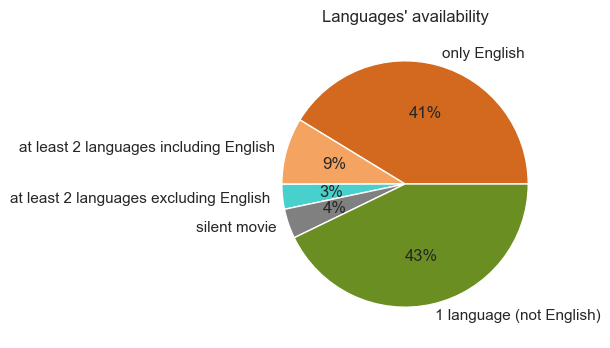

In [112]:
######################################## EXPLORATORY ANALYSIS OF THE TRANSLATIONS ####################################

#count number of movies available in at least 2 languages
def fct_2L_available(x):
    if isinstance(x, str):
        if x.count(',')>=1: #each comma separates 2 languages, so the number of languages is the number of comma +1 
            return True 
        else :
            return False
    else :
        return False

count_2L=movie_mtd['languages'].apply(lambda x:  fct_2L_available(x)).sum()
print(f'Proportion of movies available at least in 2 languages: ', count_2L/len(movie_mtd))


#count number of movies available in at least 2 languages, but not available in English
def fct(x):
    if isinstance(x, str):
        if x.count(',')>=1 and ("english language" not in x.lower()) : #each comma separates 2 languages, so the number of languages is the number of comma +1 
            return True
        else :
            return False
    else :
        return False

count_2LnotE=movie_mtd['languages'].apply(lambda x:  fct(x)).sum()
print(f'Proportion of movies available at least in 2 languages, but not in English: ', count_2LnotE/len(movie_mtd))


#count number of movies available in at least 2 languages, including English
def fct(x):
    if isinstance(x, str):
        if x.count(',')>=1 and ("english language" in x.lower()) : #each comma separates 2 languages, so the number of languages is the number of comma +1 
            return True
        else : 
            return False
    else :
        return False

count_2L_E=movie_mtd['languages'].apply(lambda x:  fct(x)).sum()
print(f'Proportion of movies available at least in 2 languages, including English: ', count_2L_E/len(movie_mtd))


#the case of silent movies : we could consider that they are available in all languages, but it is surely negligeable...
count_silent=movie_mtd['languages'].apply(lambda x: 'silent film' in x.lower() if isinstance(x, str) else False).sum()
print(f'Proportion of silent movies: ', count_silent/len(movie_mtd))
#they are not that negligeable...


#proportion of movies available in English

#calculate proportion of movies available in English
def english_available(x):
    if isinstance(x, str):
        if ("english language" in x.lower()) :
            return True
        else :
            return False
    else :
        return False

count_E = movie_mtd['languages'].apply(lambda x: english_available(x)).sum()  
print(f'Proportion of movies available at least in English: ', count_E/len(movie_mtd))


#proportion of movies available only in English
def fct(x):
    if isinstance(x, str):
        if ("english language" in x.lower()) and x.count(',')==0 : 
            return 1
        else :
            return 0
    else :
        return 0
count_onlyE=movie_mtd['languages'].apply(lambda x:  fct(x)).sum()
print(f'Proportion of movies available only in English: ', count_onlyE/len(movie_mtd))

############################################# PIE CHARTS ############################################### 
rest=100-count_onlyE*100/len(movie_mtd)- count_2LnotE*100/len(movie_mtd)- (count_2L*100/len(movie_mtd)-count_2LnotE*100/len(movie_mtd))-count_silent*100/len(movie_mtd)

data = [count_onlyE*100/len(movie_mtd),  count_2L*100/len(movie_mtd)-count_2LnotE*100/len(movie_mtd), count_2LnotE*100/len(movie_mtd),count_silent*100/len(movie_mtd), rest] 
keys = ['only English', 'at least 2 languages including English', 'at least 2 languages excluding English', 'silent movie', '1 language (not English)'] 
plt.figure(figsize=(4, 4))
sns.set_theme(style="darkgrid")
plt.title("Languages' availability")
# plot a pie chart
plt.pie(data, labels=keys, colors=['chocolate','sandybrown','mediumturquoise','grey','olivedrab'], autopct='%.0f%%')  
plt.show() 



The calculated p-value is 4.1333356288440356e-10.
The difference in means is statistically significant for an alpha-level of 0.05.


C:\Users\Claire PINSON\AppData\Local\Temp\ipykernel_33396\1416902651.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.boxplot(movie_mtd, x='english available', y='box_office', palette='pastel')
C:\Users\Claire PINSON\AppData\Local\Temp\ipykernel_33396\1416902651.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No','Yes'])


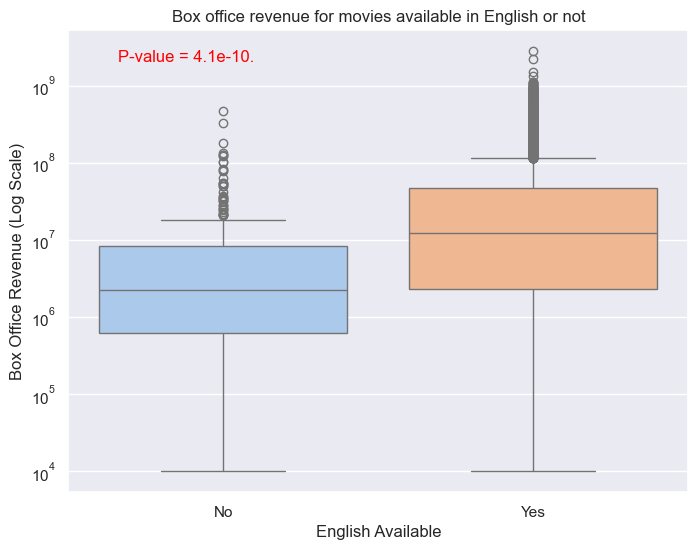

In [106]:
#how different is the bow office revenue for movies available in English vs not available in English ? t-test for significance
#box plots
def fct(x):
    if isinstance(x, str):
        if "english"  in x.lower() : #each comma separates 2 languages, so the number of languages is the number of comma +1 
            return 1
    else :
        return 0
movie_mtd['english available']=movie_mtd['languages'].apply(lambda x: fct(x))

######################################## Statistical test ##############################################""
#are the means significantly different ?
alpha=0.05
statistic, p_value=ttest_ind(movie_mtd[movie_mtd['english available']==1]['box_office'].dropna(), movie_mtd[movie_mtd['english available']==0 ]['box_office'].dropna())
print(f'The calculated p-value is {p_value}.')
if p_value<alpha :
    print(f'The difference in means is statistically significant for an alpha-level of {alpha}.')
else :
    print(f'The difference in means is NOT statistically significant for an alpha-level of {alpha}.')

####################sns.boxplot à regarder ########### (serie data visualisation)
plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
ax=sns.boxplot(movie_mtd, x='english available', y='box_office', palette='pastel')
#oxplot=movie_mtd.boxplot('box_office', by='english available')
plt.yscale('log') #because otherwise the outliers are overwhelming in the plot
plt.title('Box office revenue for movies available in English or not')
plt.suptitle('') #to remove the automatic subtitle of .boxplot
ax.set_xticklabels(['No','Yes'])
plt.xlabel('English Available')
plt.ylabel('Box Office Revenue (Log Scale)')
#the x and y positions are in the images coordinates (log scale x linear scale)
ax.text(0.1, 2*10**9, f'P-value = {p_value:.1e}.', ha='right', fontsize=12, color='red')

plt.show()


In [108]:
#we will consider separetly the movies produced only by the US from movies produced only partially by the US
#isolate them in datasets
movie_mtd_strict_us=movie_mtd[movie_mtd['countries']=='United States of America']
movie_mtd_incl_us=movie_mtd[movie_mtd['countries'].str.contains('United States of America', na=False) & movie_mtd['countries'].str.contains(',', na=False) ]


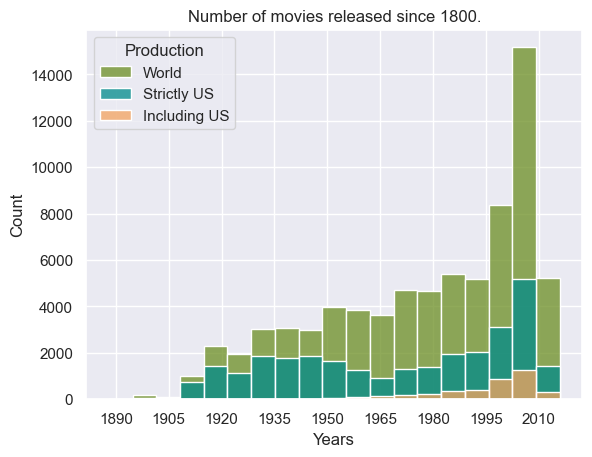

The last bar is low... this is probably because the last date of the dataset does not reach the upper bound of that bin.


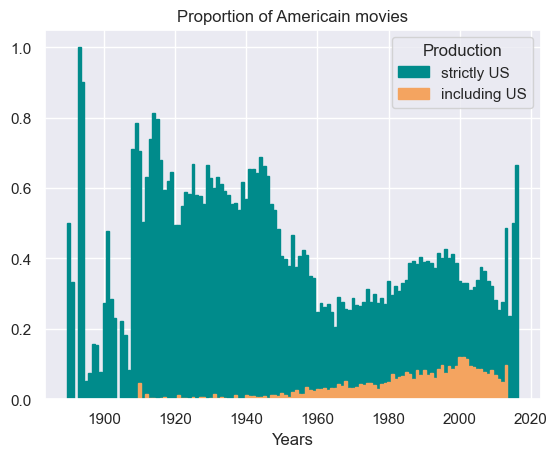

In [116]:
#distribution of released movies over time :
num_bins=20
bin_edges = np.linspace(min(movie_mtd['release_year']), max(movie_mtd['release_year']), num_bins)


fig, ax = plt.subplots()
sns.histplot(data=movie_mtd, x='release_year', bins=bin_edges, color='olivedrab', label='World')
sns.histplot(data=movie_mtd_strict_us, x='release_year', bins=bin_edges, color='darkcyan', label='Strictly US' )
sns.histplot(data=movie_mtd_incl_us, x='release_year', bins=bin_edges, color='sandybrown', label='Including US' )


ax.xaxis.set_major_locator(MaxNLocator(10))
plt.title('Number of movies released since 1800.')
plt.xlabel('Years')
plt.legend(title='Production')
plt.show()

print('The last bar is low... this is probably because the last date of the dataset does not reach the upper bound of that bin.')

# Plot of the evolution of the proportion of americain movies over time
# pareil pour les autres langages (établir si des langages sont devenus 'populaires' au fil du temps)

nbins=np.arange(min(movie_mtd['release_year']), max(movie_mtd['release_year'])+1)

prop_incl_us=(movie_mtd_incl_us.groupby('release_year')['wiki_movie_ID'].count()/movie_mtd.groupby('release_year')['wiki_movie_ID'].count())
prop_strict_us=(movie_mtd_strict_us.groupby('release_year')['wiki_movie_ID'].count()/movie_mtd.groupby('release_year')['wiki_movie_ID'].count())

fig, ax = plt.subplots()
plt.bar(nbins, prop_strict_us, width=0.8, color = 'darkcyan', edgecolor='darkcyan', label='strictly US')
plt.bar(nbins, prop_incl_us, width=0.8, color = 'sandybrown', edgecolor='sandybrown', label='including US')
plt.title('Proportion of Americain movies')
plt.legend(title='Production')
plt.xlabel('Years')
plt.show()

In [110]:
############################ TRANSLATIONS AMONG GENRES #############################
    
#the column of genre can contain many genres, to do so we explode the dataset according to the genres
movies_mtd_genre_exploded=movie_mtd.copy()
movies_mtd_genre_exploded['genres_IMDB'] = movies_mtd_genre_exploded['genres_IMDB'].str.split(',') #creates a list with the genres

#we create a row for each genre, so each movie genre is duplicated to have one genre/row
movies_mtd_genre_exploded = movies_mtd_genre_exploded.explode('genres_IMDB')
#reset index to avoid problems latter with the groupby
movies_mtd_genre_exploded = movies_mtd_genre_exploded.reset_index(drop=True)

#count the number of traductions for each genre among all movies
#each comma separates 2 languages, so the number of languages is the number of comma +1, the number of translations is the number of comma

def language_count(x):
    if isinstance(x, str):
        return  x.count(',')     
    else :
        return False
    
movies_mtd_genre_exploded['translations_count']=movies_mtd_genre_exploded['languages'].apply(lambda x: language_count(x))

######################## Isolate us movies from this dataset ##################

#strictly aericain movies
movies_mtd_strict_us_genre_exploded=movies_mtd_genre_exploded[movies_mtd_genre_exploded['countries'].apply(lambda x: x.lower()=='united states of america' if isinstance(x, str) else False)]
#movies produced by US but not only
movies_mtd_incl_us_genre_exploded=movies_mtd_genre_exploded[movies_mtd_genre_exploded['countries'].str.contains('United States of America', na=False) & movie_mtd['countries'].str.contains(',', na=False)]

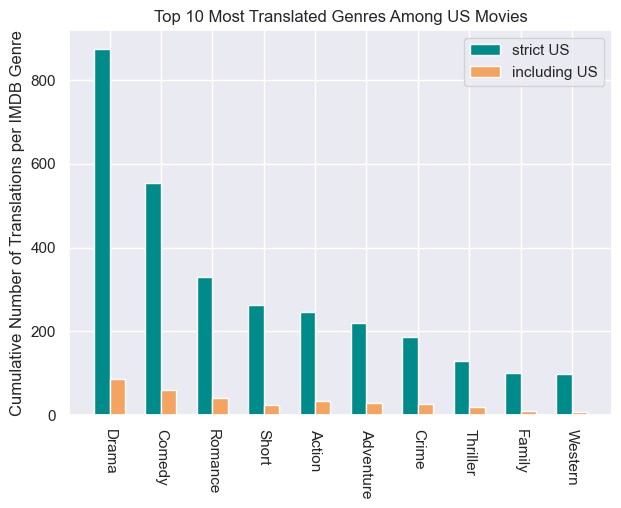

In [111]:
#basé sur les films produits aux US, est-ce que le genre le plus traduit (vers toutes langues confondues) a évolué ? 

#quel est le genre qui cumule le plus de traductions parmi les films américain ?
#parmi les films américains, calculer le nombre de traductions par film puis groupby genre de film et sum()
#la colonne 'countries' est tjrs des strings


groupby_genre_translation_strict_us=movies_mtd_strict_us_genre_exploded['translations_count'].groupby(movies_mtd_strict_us_genre_exploded['genres_IMDB']).sum()
groupby_genre_translation_incl_us=movies_mtd_incl_us_genre_exploded['translations_count'].groupby(movies_mtd_incl_us_genre_exploded['genres_IMDB']).sum()


#parameters
width = 0.3
n=10

#top 10 genres for movies strictly produced by US
top_genres_strict_us = groupby_genre_translation_strict_us.sort_values(ascending=False).head(n)
#we want to reorder the genres of movies partially produced by the US to match that previous top 10 genres (of movies strictly produced by US)
#to do so, we reindex 
corresponding_genres_incl_us = groupby_genre_translation_incl_us.reindex(top_genres_strict_us.index)

######################################## Plotting ######################################
fig, ax = plt.subplots(figsize=(7, 5))

# Plot the bars side by side
ax.bar(np.arange(n) - width/2, top_genres_strict_us, width=width, label='strict US', color='darkcyan')
ax.bar(np.arange(n) + width/2, corresponding_genres_incl_us, width=width, label='including US', color='sandybrown')

# Add labels and titles
ax.legend()
ax.set_title('Top 10 Most Translated Genres Among US Movies')
ax.set_ylabel('Cumulative Number of Translations per IMDB Genre')
ax.set_xticks(np.arange(n))
ax.set_xticklabels(groupby_genre_translation_strict_us.sort_values(ascending=False).head(n).index,rotation=-90)

plt.show()

     release_year  wiki_movie_ID
0          1899.0              1
1          1900.0              3
2          1901.0              2
3          1905.0              1
4          1906.0              1
..            ...            ...
106        2008.0            301
107        2009.0            291
108        2010.0            249
109        2011.0            225
110        2012.0            108

[111 rows x 2 columns]


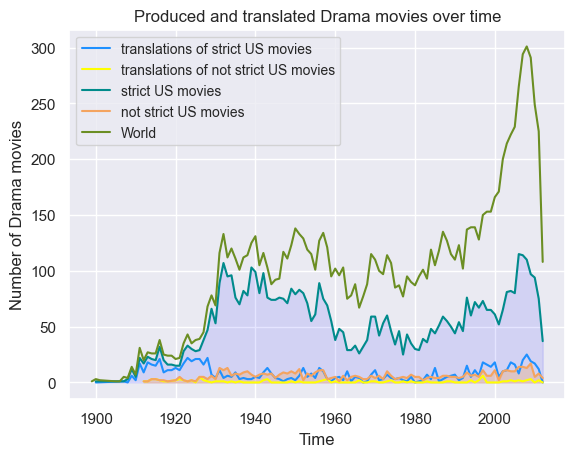

In [124]:
#what is the evolution of top1 (DRAMA movies) translated over time ?

'''#create a dataset exploded by genre but for every movie, not only us movies (as above)
movies_mtd_genre_exploded=movie_mtd.copy()
movies_mtd_genre_exploded['genres_IMDB'] = movies_mtd_genre_exploded['genres_IMDB'].str.split(',') #creates a list with the genres
#we create a row for each genre, so each movie genre is duplicated to have one genre/row
movies_mtd_genre_exploded = movies_mtd_genre_exploded.explode('genres_IMDB')
#reset index to avoid problems latter with the groupby
movies_mtd_genre_exploded = movies_mtd_genre_exploded.reset_index(drop=True)'''

def language_count(x):
    if isinstance(x, str):
        return  x.count(',')     
    else :
        return False
movies_mtd_genre_exploded['translations_count']=movies_mtd_genre_exploded['languages'].apply(lambda x: language_count(x))


###########################################################################################

#count number of DRAMA movies produced per year in the world
#.reset_index() to use in the sns.linepolt()
drama_produced_total = movies_mtd_genre_exploded[movies_mtd_genre_exploded['genres_IMDB']=='Drama']['wiki_movie_ID'].groupby(movies_mtd_genre_exploded['release_year']).count().reset_index()
print(drama_produced_total)


#count number of DRAMA movies produced per year in the US (strict/including)
#.reset_index() to use in the sns.linepolt()
drama_produced_strict_us = movies_mtd_strict_us_genre_exploded[movies_mtd_strict_us_genre_exploded['genres_IMDB']=='Drama']['wiki_movie_ID'].groupby(movies_mtd_strict_us_genre_exploded['release_year']).count().reset_index()
drama_produced_incl_us = movies_mtd_incl_us_genre_exploded[movies_mtd_incl_us_genre_exploded['genres_IMDB']=='Drama']['wiki_movie_ID'].groupby(movies_mtd_incl_us_genre_exploded['release_year']).count().reset_index()

#Evolution of translations of US Drama movies (strict/including)
drama_translated_strict_us = movies_mtd_strict_us_genre_exploded[movies_mtd_strict_us_genre_exploded['genres_IMDB']=='Drama']['translations_count'].groupby(movies_mtd_strict_us_genre_exploded['release_year']).sum().reset_index()
drama_translated_incl_us = movies_mtd_incl_us_genre_exploded[movies_mtd_incl_us_genre_exploded['genres_IMDB']=='Drama']['translations_count'].groupby(movies_mtd_incl_us_genre_exploded['release_year']).sum().reset_index()



################################################# PLOT ##################################################
sns.set_theme(style="darkgrid")

# Plot Number of produced Drama movies in the US & in the World
sns.lineplot(data=drama_translated_strict_us, x='release_year', y='translations_count', label="translations of strict US movies", color='dodgerblue') #use y='wiki_movie_ID' because we did the groupby on this colomn before counting on the groupby
sns.lineplot(data=drama_translated_incl_us, x='release_year', y='translations_count', label="translations of not strict US movies", color='yellow') #use y='wiki_movie_ID' because we did the groupby on this colomn before counting on the groupby

sns.lineplot(data=drama_produced_strict_us, x='release_year', y='wiki_movie_ID', label="strict US movies", color='darkcyan') #use y='wiki_movie_ID' because we did the groupby on this colomn before counting on the groupby
sns.lineplot(data=drama_produced_incl_us, x='release_year', y='wiki_movie_ID', label="not strict US movies", color='sandybrown') #use y='wiki_movie_ID' because we did the groupby on this colomn before counting on the groupby

sns.lineplot(data=drama_produced_total, x='release_year', y='wiki_movie_ID', label='World', color='olivedrab') #use y='wiki_movie_ID' because we did the groupby on this colomn before counting on the groupby
plt.fill_between(drama_produced_strict_us['release_year'], drama_produced_strict_us['wiki_movie_ID'] , color='blue', alpha=0.1)
plt.fill_between(drama_produced_incl_us['release_year'], drama_produced_incl_us['wiki_movie_ID'] , color='sandybrown', alpha=0.3)
#plt.fill_between(drama_translated_us['release_year'], drama_translated_us['translations_count'] , color='darkcyan', alpha=0.1)

plt.xlabel("Time")
#plt.yscale('log')
plt.ylabel("Number of Drama movies")
plt.title("Produced and translated Drama movies over time")
plt.legend(loc='upper left', fontsize=10, title_fontsize='12')
plt.show()


### 1.2 Exploratory analysis of the dataset according to our research questions
- main plots 
- organiser en sous section suivnat les research questions (à voir)
- rajouter des cells en markdown qui expliquent nos plots
- **essayer de faire des liens avec nos recherches questions dans nos textes pour voir la cohérence de l'ensemble**

# 2. Character metadata enriched with wikipedia actor's nationality

### 2.1 General information about the dataset
- pie charts and print statements + basics stats

### 2.2 Exploratory analysis of the dataset according to our research questions
- main plots 
- organiser en sous section suivnat les research questions (à voir)
- rajouter des cells en markdown qui expliquent nos plots
- **essayer de faire des liens avec nos recherches questions dans nos textes pour voir la cohérence de l'ensemble**